# Learning how to "Web scraping":
This Jupyter Notebook is a 4fun mini project to learn more about how scraping an webpage works.
Bellow are the needed imports

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import time
from PIL import Image
import matplotlib.gridspec as gridspec
import numpy as np

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By

## The Actual Sraping using Selenium

The goal was to be able to access and extract data like the following:
- Monster's Name,
- Monster's HP,
- Tower Identification,
- Etc.

Because some of dynamically placed in the HTML, using Selenium over others options looked like the best solution.
By opening the web brownser we are loading the data that is dynamically placed in the page, so it becomes accessiable to be scrapped.

### First, how to start the web brownser

In [2]:
service = Service()
options = webdriver.ChromeOptions()
driver = webdriver.Chrome(service=service, options=options)

### Creating the starting DataFrames


In [3]:
#Table about Enemies Data
col_names = ['ID', 'SIDE', 'ENEMY NAME', 'ENEMY HP']

#Table for Overall Data
col_names2 = ['ID', 'SIDE', 'ELEMENTAL BUFF', 'TOTAL HP']

df_enemies = pd.DataFrame(columns=col_names)
df_overall = pd.DataFrame(columns=col_names2)

#print(df_enemies)
#print(df_overall)

### Accessing and Extracting the data dynamically from the ToA's pages 
This is done dynamically so we can:
- Get all the data from all three tower's given an range (1, Current Version-1)


After that some processing is done so we can organize the data in a easier way to manipulate and analyze it later.

In [ ]:
for i in range(1, 22): 
    url = f"https://ww.hakush.in/tower/{i}"
    driver.get(url)

    time.sleep(1)


    buttons = driver.find_elements(By.TAG_NAME, 'button')
    for button in buttons:
        button.click()
        time.sleep(1)

        try:
            tower_id = driver.find_element(By.CLASS_NAME, 'pb-2').text
            tower_buff = driver.find_element(By.CLASS_NAME, 'pl-3').text

            id_number = tower_id.split()[1]
            side = tower_id.split()[3]
            buff = tower_buff

            enemies_data = driver.find_elements(By.CSS_SELECTOR, 'div.flex.flex-col.p-2')
            total_hp = 0
            enemies_names = []
            enemies_hp_values = []

            for enemy in enemies_data:
                lines = enemy.text.split('\n')
                if len(lines) >= 2 and "HP:" in lines[1]:  
                    enemy_name = lines[0]
                    enemy_hp = lines[1].split()[1]
                    total_hp += int(float(enemy_hp))
                    enemies_names.append(enemy_name)
                    enemies_hp_values.append(enemy_hp)

            for name, hp in zip(enemies_names, enemies_hp_values):
                enemies_new_row = {"ID": id_number, "SIDE": side, "ENEMY NAME": name, "ENEMY HP": hp}
                df_enemies = df_enemies.append(enemies_new_row, ignore_index=True)

            overall_new_row = {"ID": id_number, "SIDE": side, "ELEMENTAL BUFF": buff, "TOTAL HP": total_hp}
            df_overall = df_overall.append(overall_new_row, ignore_index=True)

            #print(f"[✔] Torre {i} processada com sucesso.")
        except Exception as e:
            print(f"[✘] Erro ao processar torre {i}: {e}")


driver.quit()

## First look at the DataFrames with the data

In [5]:
df_enemies

,ID,SIDE,ENEMY NAME,ENEMY HP
0,1,Resonant,Electro Predator,14969
1,1,Resonant,Glacio Predator,14969
2,1,Resonant,Aero Predator,14969
3,1,Resonant,Havoc Warrior,18752
4,1,Resonant,Young Roseshroom,19573
...,...,...,...,...
536,21,Echoing,Viridblaze Saurian,20233
537,21,Echoing,Chop Chop: Headless,27719
538,21,Echoing,Cuddle Wuddle,58112
539,21,Echoing,Chop Chop,74746


In [241]:
df_overall

,ID,SIDE,ELEMENTAL BUFF,TOTAL HP
0,1,Resonant,Resonators gain 30% Aero DMG Bonus.,1101591
1,1,Hazard,Resonators gain 30% Attribute DMG Bonus.,1487681
2,1,Echoing,Resonators gain 30% Electro DMG Bonus.,697771
3,2,Resonant,Resonators gain 30% Aero DMG Bonus.,1101591
4,2,Hazard,Resonators gain 30% Attribute DMG Bonus.,1487681
...,...,...,...,...
58,20,Hazard,Enemy Spectro RES and Fusion RES are decreased...,1483672
59,20,Echoing,Enemy Glacio RES decreases by 10%,1250274
60,21,Resonant,Enemy Spectro RES decreases by 10%,976917
61,21,Hazard,Enemy Fusion RES and Havoc RES are decreased b...,1613417


## Transforming the Data

### This is a small function to format the numbers that will be shown in the graph later.

In [13]:
# Label formatter
def label_formatter(pct, allvals):
    absolute = int(round(pct/100.*sum(allvals)))
    return f"{absolute} ({pct:.1f}%)"

### What 4-Cost Echoes (Calamity or Overlord Class Echoes) have been in Tower of Adversity so far

In [14]:
bosses_names = ['Tempest Mephis', 'Crownless', 'Feilian Beringal', 'Lampylumen Myriad', 'Mourning Aix',
                'Mech Abomination', 'Impermanence Heron', 'Dreamless', 'Jué', 'Fallacy of No Return', 'Lorelei', 
                'Sentry Construct', 'Dragon of Dirge', 'Hecate', 'Reminiscence: Fleurdelys', 'Thundering Mephis', 
                'Bell-Borne Geochelone', 'Inferno Rider']

df = df_enemies
df_filtered_bosses = df[df['ENEMY NAME'].isin(bosses_names)]

df_result = pd.DataFrame(df_filtered_bosses['ENEMY NAME'].value_counts()).reset_index()
df_result.columns = ['Boss', 'Ocurrance']
df_result = df_result.sort_values(by='Ocurrance', ascending=False).reset_index(drop=True)

#### Ploting the Graph (4-Cost Echoes in ToA)

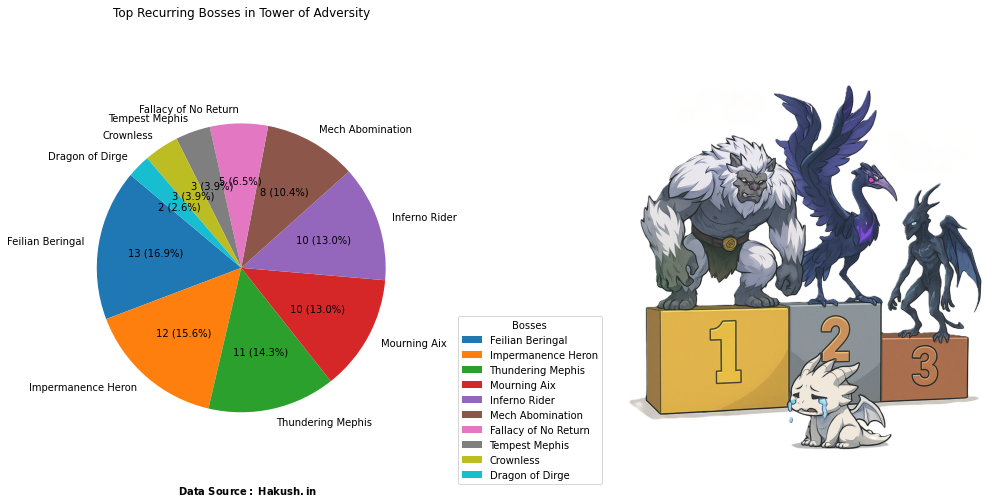

In [ ]:
img_path = "./img/ToABossesPodium.png"
img = Image.open(img_path)

fig = plt.figure(figsize=(14, 7))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.2])

ax0 = plt.subplot(gs[0])
wedges, texts, autotexts = ax0.pie(
    df_result['Ocurrance'],
    labels=df_result['Boss'],
    autopct=lambda pct: label_formatter(pct, df_result['Ocurrance']),
    startangle=140
)
ax0.set_title('Top Recurring Bosses in Tower of Adversity', pad=30)
ax0.axis('equal')
ax0.legend(
    wedges,
    df_result['Boss'],
    title="Bosses",
    loc="lower right",
    bbox_to_anchor=(1, 0, 0.65, 1)
)

#AI generated img placement
ax1 = plt.subplot(gs[1])
ax1.imshow(img)
ax1.axis('off')
fig.patch.set_facecolor('white')

#Note
plt.figtext(
    0.18,
    0.01,
    r"$\bf{Data\ Source:\ Hakush.in}$",
    wrap=True,
    horizontalalignment='left',
    fontsize=10,
    style='italic'
)

plt.tight_layout()
plt.show()

### What is the Most Buffed Element DMG in ToA so far?

Notes: 
- This graph will only take in consideration buffs that are directly related to an element.
- This will only take in consideration the 1st Buff Slot of Tower of Adversity and some more generic buffs like "ATTRIBUTE DMG BONUS" will not be considered.

In [20]:
elements = ['Electro', 'Aero', 'Spectro', 'Fusion', 'Glacio', 'Havoc', 'Attribute DMG']
dict_elements_buff = {el: 0 for el in elements}
dict_elements_buff['Others'] = 0 

dict_elements_debuff = {el: 0 for el in elements}
dict_elements_debuff['Others'] = 0 

df = df_overall
df_result = df['ELEMENTAL BUFF'].value_counts().reset_index()
df_result.columns = ['buff', 'count']

# Novos dataframes
buff_rows = []
debuff_rows = []

for _, row in df_result.iterrows():
    text = row['buff']
    count = row['count']

     # Verifica se tem vírgula
    if ',' in text:
        parts = text.split(',', 1)
        buff_part = parts[0].strip()
        debuff_part = parts[1].strip()

        buff_rows.append({'buff': buff_part, 'count': count})
        debuff_rows.append({'debuff': debuff_part, 'count': count})
    else:
        # Se não tiver vírgula, considera tudo como buff (ou podemos decidir outro critério)
        buff_rows.append({'buff': text, 'count': count})

df_result_buffs = pd.DataFrame(buff_rows)
df_result_debuffs = pd.DataFrame(debuff_rows)


for i in range(len(df_result_buffs)):
    found = False
    for element in elements:
        if element in df_result_buffs['buff'][i]:
            dict_elements_buff[element] += df_result_buffs['count'][i]
            found  = True
    if not found:
        dict_elements_buff['Others'] += df_result_buffs['count'][i]
print(f"Buffs:{dict_elements_buff} ")

for i in range(len(df_result_debuffs)):
    found = False
    for element in elements:
        if element in df_result_debuffs['debuff'][i]:
            dict_elements_debuff[element] += df_result_debuffs['count'][i]
            found  = True
    if not found:
        dict_elements_debuff['Others'] += df_result_debuffs['count'][i]
print(f"Debuffs: {dict_elements_debuff}")

#Dicts to df
df_buffs = pd.DataFrame({
    'buffs': list(dict_elements_buff.keys()),
    'count': list(dict_elements_buff.values())
})

df_debuffs = pd.DataFrame({
    'debuffs': list(dict_elements_debuff.keys()),
    'count': list(dict_elements_debuff.values())
})

print(df_debuffs[:-2].sort_values(by='count', ascending=True))

Buffs:{'Electro': 9, 'Aero': 7, 'Spectro': 12, 'Fusion': 8, 'Glacio': 6, 'Havoc': 7, 'Attribute DMG': 16, 'Others': 3} 
Debuffs: {'Electro': 3, 'Aero': 2, 'Spectro': 0, 'Fusion': 1, 'Glacio': 2, 'Havoc': 2, 'Attribute DMG': 0, 'Others': 0}
   debuffs  count
2  Spectro      0
3   Fusion      1
1     Aero      2
4   Glacio      2
5    Havoc      2
0  Electro      3


#### Plotting the Graph (Buffed Element with the most occurance)

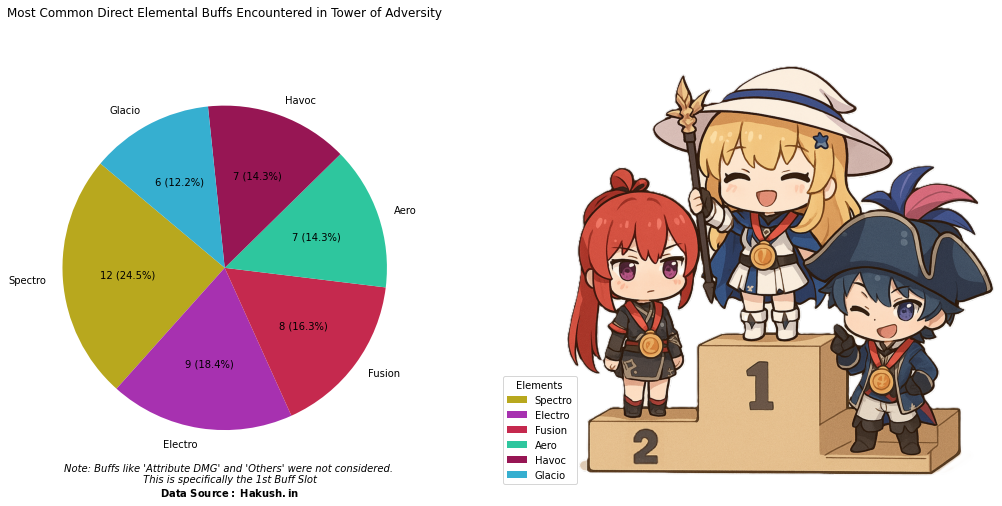

In [ ]:
img_path = "./img/ToAElementalBuffPodium.png"
img = Image.open(img_path)

df_buffs = df_buffs[:-2].sort_values(by='count', ascending=False).reset_index(drop=True)

fig = plt.figure(figsize=(14, 7))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.2])

element_colors = {
    'Fusion': '#c5294e',      
    'Glacio': '#36afd0',      
    'Electro': '#a731b0',     
    'Havoc': '#971654',       
    'Spectro': '#b8a81e',   
    'Aero': '#2ec69e',        
}
colors = [element_colors.get(elem, '#D3D3D3') for elem in df_buffs['buffs']]

ax0 = plt.subplot(gs[0])
wedges, texts, autotexts = ax0.pie(
    df_buffs['count'],
    labels=df_buffs['buffs'],
    autopct=lambda pct: label_formatter(pct, df_buffs['count']),
    startangle=140,
    colors=colors 
)
ax0.set_title('Most Common Direct Elemental Buffs Encountered in Tower of Adversity', pad=30)
ax0.axis('equal')
ax0.legend(
    wedges,
    df_buffs['buffs'],
    title="Elements",
    loc="lower right",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

ax1 = plt.subplot(gs[1])
ax1.imshow(img)
ax1.axis('off')  
fig.patch.set_facecolor('white')

# Note
plt.figtext(
    0.23,
    0.01,
    "Note: Buffs like 'Attribute DMG' and 'Others' were not considered. \n This is specifically the 1st Buff Slot \n" + r"$\bf{Data\ Source:\ Hakush.in}$",
    wrap=True,
    horizontalalignment='center',
    fontsize=10,
    style='italic'
)


plt.tight_layout()
plt.show()

#### Plotting the Graph (Element with the least debuff occurance)

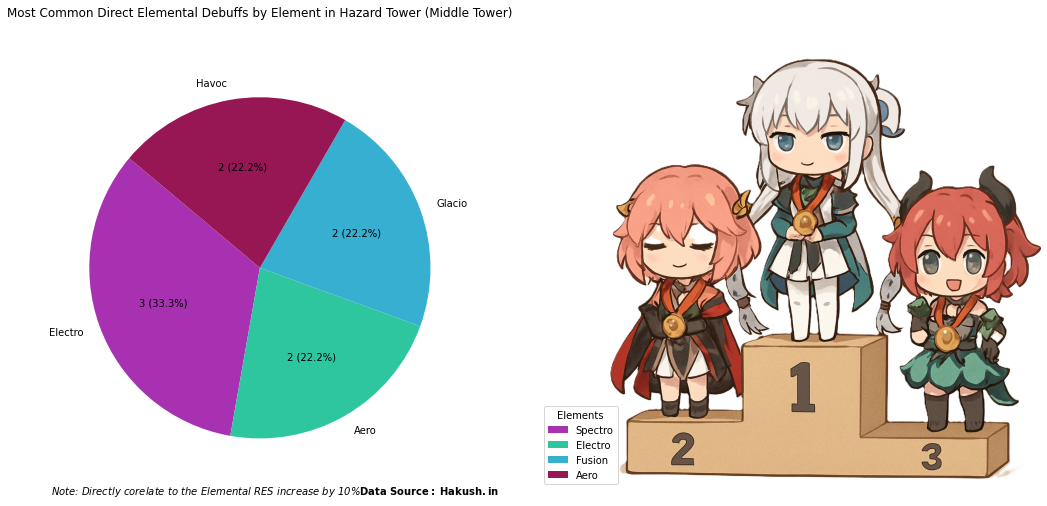

In [ ]:
img_path = "./img/ToAElementalDebuffPodium.png"
img = Image.open(img_path)

df_debuffs = df_debuffs[:-2].sort_values(by='count', ascending=False).reset_index(drop=True)

fig = plt.figure(figsize=(14, 7))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.2])

#Refer to Colors
colors = [element_colors.get(elem, '#D3D3D3') for elem in df_debuffs['debuffs']]

ax0 = plt.subplot(gs[0])
wedges, texts, autotexts = ax0.pie(
    df_debuffs['count'],
    labels=df_debuffs['debuffs'],
    autopct=lambda pct: label_formatter(pct, df_debuffs['count']),
    startangle=140,
    colors=colors 
)
ax0.set_title('Most Common Direct Elemental Debuffs by Element in Hazard Tower (Middle Tower)', pad=30)
ax0.axis('equal')
ax0.legend(
    wedges,
    df_buffs['buffs'],
    title="Elements",
    loc="lower right",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

ax1 = plt.subplot(gs[1])
ax1.imshow(img)
ax1.axis('off')  
fig.patch.set_facecolor('white')

# Note
plt.figtext(
    0.23,
    0.01,
    "Note: Directly corelate to the Elemental RES increase by 10% " + r"$\bf{Data\ Source:\ Hakush.in}$",
    wrap=True,
    horizontalalignment='center',
    fontsize=10,
    style='italic'
)


plt.tight_layout()
plt.show()

### Let's try to check HP Inflation

#### Doing the SUM of Total HP per Tower's Floor

In [ ]:
df = df_overall
columns = ['ID', 'HP SUM']
df_result = pd.DataFrame(columns=columns)

real_id = 1
for i in range(0, len(df), 3):
    hp_sum = df['TOTAL HP'][i] + df['TOTAL HP'][i+1] + df['TOTAL HP'][i+2]
    new_row = {"ID": real_id, "HP SUM": hp_sum}

    df_result = df_result.append(new_row, ignore_index=True)
    real_id+=1
df_result

#### Attaching the info of Patch for each Reset ID

In [230]:
df_hp = df_result.copy()
base_hp = df_hp.loc[df_result['ID'] == 1 , 'HP SUM'].values[0]

df_hp['% Increase'] = ((df_hp['HP SUM'] - base_hp) / base_hp) * 100


patches_by_reset = [
    "1.0", "1.0", "1.0",
    "1.1", "1.1", "1.1",
    "1.2", "1.2", "1.2",
    "1.3", "1.3", "1.3", "1.3",
    "1.4", "1.4", "1.4",
    "2.0", "2.0", "2.0",
    "2.1", 
    "2.2"
]

df_hp['Patch'] = patches_by_reset
df_hp

,ID,HP SUM,% Increase,Patch
0,1,3287043,0.0,1.0
1,2,3287043,0.0,1.0
2,3,3296413,0.285059,1.0
3,4,3296413,0.285059,1.1
4,5,3142211,-4.406149,1.1
5,6,3142211,-4.406149,1.1
6,7,3376633,2.72555,1.2
7,8,3376633,2.72555,1.2
8,9,3142248,-4.405023,1.2
9,10,3180522,-3.240633,1.3


#### Plotting the Hp Inflation Graph

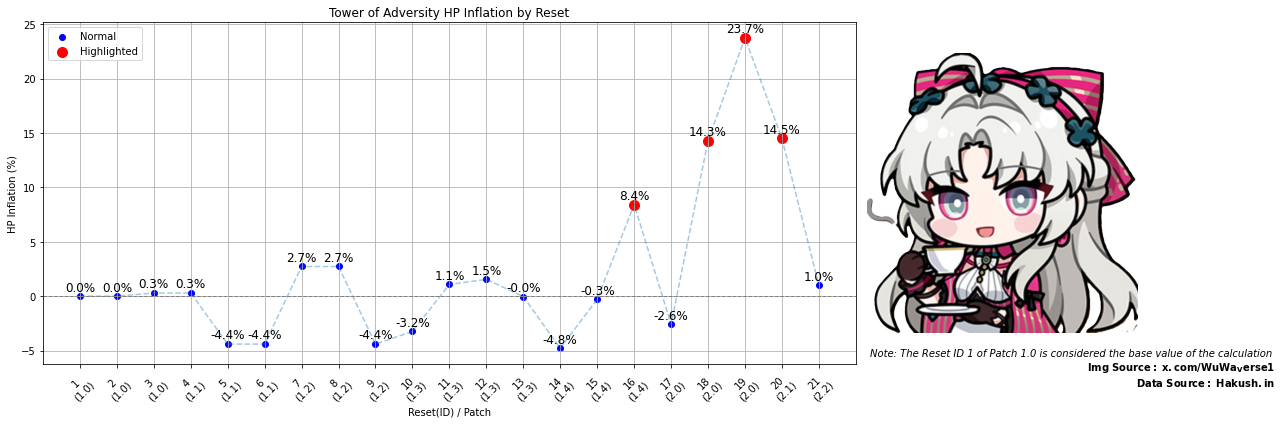

In [ ]:
# Caminho e carregamento da imagem
img_path = "./img/Carllota Chibi.png"
img = Image.open(img_path)

# IDs a destacar
highlight_ids = [16, 18, 19, 20]

# Converte os tipos corretamente
df_hp['ID'] = pd.to_numeric(df_hp['ID'], errors='coerce')
df_hp['% Increase'] = pd.to_numeric(df_hp['% Increase'], errors='coerce')
df_hp['HP SUM'] = pd.to_numeric(df_hp['HP SUM'], errors='coerce')
df_hp['Patch'] = df_hp['Patch'].astype(str)

# Coordenadas X e Y
x = df_hp['ID']
y = df_hp['% Increase']

# Criar subplots: 1 linha, 2 colunas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [3, 1]})

# Gráfico no primeiro eixo (esquerda)
ax1.scatter(x, y, color='b', label='Normal')
ax1.plot(x, y, linestyle='--', alpha=0.4)

# Destaques
highlight_data = df_hp[df_hp['ID'].isin(highlight_ids)]
ax1.scatter(highlight_data['ID'], highlight_data['% Increase'],
            color='r', edgecolor='red', s=100, label='Highlighted')

# Configurações do gráfico
ax1.set_title('Tower of Adversity HP Inflation by Reset')
ax1.set_xlabel('Reset(ID) / Patch')
ax1.set_ylabel('HP Inflation (%)')
ax1.grid(True)
ax1.axhline(0, color='gray', linestyle='--', linewidth=1)

# Rótulos do eixo X
xtick_labels = [f'{id_}\n({patch})' for id_, patch in zip(df_hp['ID'], df_hp['Patch'])]
ax1.set_xticks(x)
ax1.set_xticklabels(xtick_labels, rotation=45)

# Valores sobre os pontos
for i, value in enumerate(y):
    ax1.text(x.iloc[i], y.iloc[i] + 0.5, f'{value:.1f}%', ha='center', fontsize=12)

ax1.legend()

# Imagem no segundo eixo (direita)
ax2.imshow(img)
ax2.axis('off')  

# Note
plt.figtext(
    1.11,
    0.1,
    "Note: The Reset ID 1 of Patch 1.0 is considered the base value of the calculation \n" + r"$\bf{Img\ Source:\ x.com/WuWa_Verse1}$" + "\n" +  r"$\bf{Data\ Source:\ Hakush.in}$",
    wrap=True,
    horizontalalignment='right',
    fontsize=10,
    style='italic'
)

plt.tight_layout()
plt.show()

### Hp Inflation between the same 4-cost Echoes?

In [238]:
df_sorted_bosses = df_filtered_bosses.sort_values(by='ENEMY NAME', ascending=False).reset_index(drop=True)
unique_bosses_list = [boss for boss in pd.unique(df_sorted_bosses['ENEMY NAME'])]

lowest_highest_list = []
for boss in unique_bosses_list:
    current = 0
    highest = 0
    lowest = 0
    for i, row in df_sorted_bosses.iterrows():
       if boss == row['ENEMY NAME']:
            current = int(row['ENEMY HP'])
            
            if highest < current:
                highest = current
            if lowest > current or lowest == 0: 
                lowest = current

    lowest_highest_list.append([lowest, highest])

for boss, hp_variation in zip(unique_bosses_list, lowest_highest_list):
    print(boss, hp_variation)

df_bosses_groupby = df_sorted_bosses.groupby(['ENEMY NAME', 'ENEMY HP']).size().reset_index(name='occurrence')
print(df_bosses_groupby)


Thundering Mephis [459298, 637422]
Tempest Mephis [369487, 512780]
Mourning Aix [435138, 603892]
Mech Abomination [460348, 638880]
Inferno Rider [468489, 650178]
Impermanence Heron [419907, 582754]
Feilian Beringal [453258, 629039]
Fallacy of No Return [435138, 603892]
Dragon of Dirge [535716, 535716]
Crownless [181198, 251470]
              ENEMY NAME ENEMY HP  occurrence
0              Crownless   181198           2
1              Crownless   251470           1
2        Dragon of Dirge   535716           2
3   Fallacy of No Return   435138           4
4   Fallacy of No Return   603892           1
5       Feilian Beringal   453258           3
6       Feilian Beringal   629039          10
7     Impermanence Heron   419907           6
8     Impermanence Heron   582754           6
9          Inferno Rider   468489           5
10         Inferno Rider   650178           5
11      Mech Abomination   460348           2
12      Mech Abomination   638880           6
13          Mourning Aix  

#### Plotting the Side-by-Side Bar Graph

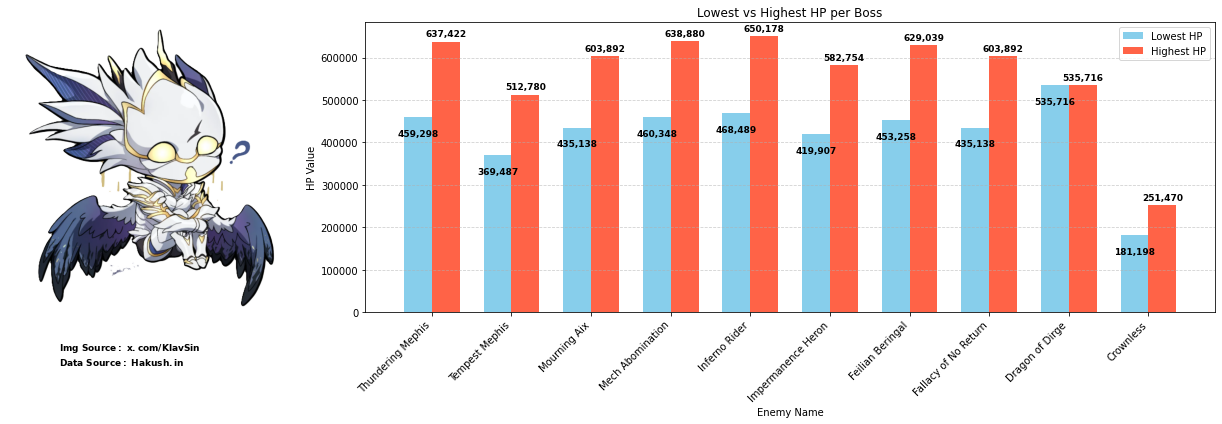

In [ ]:
# Caminho e carregamento da imagem
img_path = "./img/CrownlessChibi.png"
img = Image.open(img_path)

# Dados de entrada
bosses = unique_bosses_list
low_values = [pair[0] for pair in lowest_highest_list]
high_values = [pair[1] for pair in lowest_highest_list]

# Configurações do eixo X
x = np.arange(len(bosses))
width = 0.35

# Figura com 2 colunas: [imagem | gráfico]
fig = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2], wspace=0)

# Subplot da imagem
ax_img = plt.subplot(gs[0])
ax_img.axis('off')  # remove eixos
ax_img.imshow(img)

# Subplot do gráfico
ax = plt.subplot(gs[1])

bars1 = ax.bar(x - width/2, low_values, width, label='Lowest HP', color='skyblue')
bars2 = ax.bar(x + width/2, high_values, width, label='Highest HP', color='tomato')

# Eixos e títulos
ax.set_title('Lowest vs Highest HP per Boss')
ax.set_xlabel('Enemy Name')
ax.set_ylabel('HP Value')
ax.set_xticks(x)
ax.set_xticklabels(bosses, rotation=45, ha='right')
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.6)

# Anotação de valores nas barras
for bar in bars1:  # Lowest HP (barra azul)
    height = bar.get_height()
    ax.annotate(f'{height:,}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, -12),  # valor dentro da barra
                textcoords="offset points",
                ha='center', va='top', fontsize=9,
                weight='bold')  # contraste com azul

for bar in bars2:  # Highest HP (barra vermelha)
    height = bar.get_height()
    ax.annotate(f'{height:,}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # valor acima da barra
                textcoords="offset points",
                color = 'black', ha='center', va='bottom', fontsize=9,
                weight='bold')

# Nota da fonte (posicionada abaixo da imagem)
fig.text(
    0.1, 0.2,
    r"$\bf{Img\ Source:\ x.com/KlavSin}$" + "\n" + r"$\bf{Data\ Source:\ Hakush.in}$",
    fontsize=9,
    style='italic',
    ha='left',
    va='top'
)

plt.tight_layout()
plt.show()
